In [1]:
%config Completer.use_jedi = False

In [2]:
from collections import deque, Counter, OrderedDict
import csv
import empath
import lime
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
import numpy as np
import os
import pandas as pd
# from pandas.io.json import json_normalize
import pickle
import re

import seaborn as sns
import string

import torch
from tqdm import tqdm
from transformers import BertModel, BertTokenizer, DistilBertTokenizer, DistilBertForSequenceClassification

# import gensim
# from gensim.models.wrappers import LdaMallet
# import spacy

In [3]:
# import lazypredict
from lazypredict.Supervised import LazyClassifier


from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import Isomap, LocallyLinearEmbedding, TSNE
from sklearn.metrics import accuracy_score, davies_bouldin_score, calinski_harabasz_score, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, Normalizer
from sklearn.svm import SVC, LinearSVC
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(20, 20))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
  # plt.title("Normalized confusion matrix")
  plt.show()

# C50 Author Labels
 -Texts initially classified correctly = 710 (so 710 texts ran through the adv generator twice(wn & kv))

    --# Misclassified/TOTAL:
          -wn: 49%
          -kv: 56%
    --# w/ good cosine sim score/misclassified
          -wn: 98%
          -kv: 99%
    --# w/ good bleu score/misclassified
          -wn: 84%
          -kv: 88%
    --# w/ good both scores/misclassified
          -wn: 84%
          -kv: 88%
    --# w/ good both scores/TOTAL
          -wn: %
          -kv: %

In [ ]:
wn = pd.read_csv(r'distilbert_finetuned_c50\c50_adversarialGenerations_wn.csv', encoding_errors='ignore')
wn = wn.drop(wn.columns[:1], axis=1)
# data = data.drop(data.columns[:3], axis=1).to_csv(r'distilbert_finetuned_c50\c50_adversarialGenerations_wn.csv')
wn

In [4]:
kv = pd.read_csv(r'distilbert_finetuned_c50\c50_adversarialGenerations_kv.csv', encoding_errors='ignore')
kv = kv.drop(kv.columns[:3], axis=1)
# data = data.drop(data.columns[:3], axis=1).to_csv(r'distilbert_finetuned_c50\c50_adversarialGenerations_wn.csv')
kv

,Original Label,Original Attribution Score,Original Text,New Label,New Attribution Score,New text,Misclassified,similarity,bleu_score
0,LABEL_17,2.51,royal bank of scotland which reports full year...,LABEL_44,3.15,non-viceducal bank-to-banking-s of scotland wh...,True,0.99,0.87
1,LABEL_28,1.06,russia is quietly importing some western grain...,LABEL_28,1.06,ukraine is quietly exporting some western non-...,False,0.98,0.39
2,LABEL_4,2.13,an official inquiry into australias financial ...,LABEL_4,1.46,an offical enquiry into australian non-economi...,False,0.93,0.00
3,LABEL_26,1.36,toronto stocks ended softer on monday after th...,LABEL_12,1.81,montreal stocks ended softer on monday after t...,True,1.00,0.94
4,LABEL_6,1.43,canadas six biggest banks are poised for a fur...,LABEL_6,1.43,canadas six largest banks are well-positioned ...,False,0.99,0.53
...,...,...,...,...,...,...,...,...,...
705,LABEL_39,3.69,conrail inc and csx corp so far have convinced...,LABEL_12,0.96,conrail ltd and csx megacorpss.. so far have c...,True,0.97,0.15
706,LABEL_12,2.08,statistics canada has admitted to making a sig...,LABEL_6,1.35,statistics canadian has admitted to making a s...,True,0.99,0.79
707,LABEL_44,2.56,scottish amicable on monday confirmed that thr...,LABEL_44,1.86,scotish amicably on monday confirmed that thre...,False,0.97,0.34
708,LABEL_5,2.59,mercury finance co said wednesday it found pro...,LABEL_22,1.92,non-methylmercury financing Co. said wednesday...,True,0.97,0.57


## Total Misclassified

In [5]:
#All misclassified texts
adv_wn = wn[wn['Misclassified'] == True]
adv_kv = kv[kv['Misclassified'] == True]
(len(adv_wn),len(adv_wn)/710), (len(adv_kv),len(adv_kv)/710)

((348, 0.49014084507042255), (397, 0.5591549295774648))

In [213]:
adv_kv

,Original Label,Original Attribution Score,Original Text,New Label,New Attribution Score,New text,Misclassified,similarity,bleu_score
0,LABEL_17,2.51,royal bank of scotland which reports full year...,LABEL_44,3.15,non-viceducal bank-to-banking-s of scotland wh...,True,0.99,0.87
3,LABEL_26,1.36,toronto stocks ended softer on monday after th...,LABEL_12,1.81,montreal stocks ended softer on monday after t...,True,1.00,0.94
9,LABEL_41,2.22,sun microsystems inc said monday it will move ...,LABEL_31,0.90,sunlight- microsystems corp said monday it wil...,True,0.99,0.60
10,LABEL_46,3.06,international business machines corp unveiled ...,LABEL_9,1.59,inter-national enterprises machine corp unveil...,True,0.99,0.78
11,LABEL_46,1.56,america online inc said monday it was starting...,LABEL_22,2.78,america on-line inc said monday it was startin...,True,0.98,0.87
...,...,...,...,...,...,...,...,...,...
702,LABEL_8,2.20,the british government on thursday referred a ...,LABEL_24,2.16,the britsh government on thursday referred a p...,True,0.99,0.94
704,LABEL_38,2.42,some 120 eurotunnel sa plc employees are worki...,LABEL_8,1.27,some 120 eurotunnel si Plc. workers are work r...,True,0.98,0.49
705,LABEL_39,3.69,conrail inc and csx corp so far have convinced...,LABEL_12,0.96,conrail ltd and csx megacorpss.. so far have c...,True,0.97,0.15
706,LABEL_12,2.08,statistics canada has admitted to making a sig...,LABEL_6,1.35,statistics canadian has admitted to making a s...,True,0.99,0.79


## Cosine Similarity

In [6]:
#cosine similarity score >.9
cos_wn = adv_wn.loc[(adv_wn['similarity'] >= 0.9)]
cos_kv = adv_kv.loc[(adv_kv['similarity'] >= 0.9)]
(len(cos_wn),len(cos_wn)/348), (len(cos_kv),len(cos_kv)/397)

((341, 0.9798850574712644), (394, 0.9924433249370277))

## BLEU Score

In [7]:
#bleu score >0.4
bleu_wn = adv_wn.loc[(adv_wn['bleu_score'] >= 0.7)]
bleu_kv = adv_kv.loc[(adv_kv['bleu_score'] >= 0.7)]
(len(bleu_wn),len(bleu_wn)/348), (len(bleu_kv),len(bleu_kv)/397)

((200, 0.5747126436781609), (272, 0.6851385390428212))

In [226]:
bleu_kv.head(50)

,Original Label,Original Attribution Score,Original Text,New Label,New Attribution Score,New text,Misclassified,similarity,bleu_score
0,LABEL_17,2.51,royal bank of scotland which reports full year...,LABEL_44,3.15,non-viceducal bank-to-banking-s of scotland wh...,True,0.99,0.87
3,LABEL_26,1.36,toronto stocks ended softer on monday after th...,LABEL_12,1.81,montreal stocks ended softer on monday after t...,True,1.00,0.94
10,LABEL_46,3.06,international business machines corp unveiled ...,LABEL_9,1.59,inter-national enterprises machine corp unveil...,True,0.99,0.78
11,LABEL_46,1.56,america online inc said monday it was starting...,LABEL_22,2.78,america on-line inc said monday it was startin...,True,0.98,0.87
13,LABEL_32,1.63,voters in chad who showed little apparent enth...,LABEL_20,2.91,voters in chazs who showed little apparent ent...,True,0.97,0.92
14,LABEL_0,1.71,the merger of bankers trust new york corp and ...,LABEL_44,1.45,the merger of bankers trust new newyorkshire c...,True,1.00,0.92
18,LABEL_7,2.94,boosting the pressure on general motors corp f...,LABEL_48,2.66,boosting the pressure on general motor corp fo...,True,0.99,0.72
19,LABEL_4,4.00,media magnate rupert murdoch said on tuesday t...,LABEL_21,2.43,media magnate murdoch murdock says on tuesday ...,True,0.98,0.76
21,LABEL_9,1.36,computer distribution powerhouse ingram micro ...,LABEL_25,1.97,computer distribution powerhouse ingram macro ...,True,1.00,0.90
22,LABEL_12,2.07,the worlds gold producers will likely pay dear...,LABEL_27,1.91,the worlds silver producers will likely pay de...,True,1.00,0.82


In [228]:
adv_df = pd.concat([bleu_kv['Original Text'], bleu_kv['New text']], axis=1)
adv_df['Original Text'][107], adv_df['New text'][107]

('the chinese authorities acted decisively on friday to stop extraordinary price movements on the countrys two stock markets by imposing a limit of 10 percent in the movement of any stock on one day',
 'the non-Chinese authorites acted decisively on friday to stop extraordinary price movements on the countrys two stock markets by imposing a limit of 10 percent in the movement of any stock on one day')

## Cosine + BLEU

In [8]:
#cosine similarity score >.9 & bleu score >0.4
sim_wn = adv_wn.loc[(adv_wn['similarity'] >= 0.9) & (adv_wn['bleu_score'] >= 0.7)]
sim_kv = adv_kv.loc[(adv_kv['similarity'] >= 0.9) & (adv_kv['bleu_score'] >= 0.7)]
(len(sim_wn),len(sim_wn)/348), (len(sim_kv),len(sim_kv)/397)

((200, 0.5747126436781609), (272, 0.6851385390428212))

## Cosine + BLEU / TOTAL (out of all the originally correctly classified text)

In [9]:
# Cosine + BLEU / TOTAL
(len(sim_wn),len(sim_wn)/710), (len(sim_kv),len(sim_kv)/710)

((200, 0.28169014084507044), (272, 0.38309859154929576))

# C50 W2V Cluster Labels
 -Texts initially classified correctly = 852 (so 852 texts ran through the adv generator twice(wn & kv))

    --# Misclassified/TOTAL:
          -wn: %
          -kv: %
    --# w/ good cosine sim score/misclassified
          -wn: %
          -kv: %
    --# w/ good bleu score/misclassified
          -wn: %
          -kv: %
    --# w/ good both scores/misclassified
          -wn: %
          -kv: %
    --# w/ good both scores/TOTAL
          -wn: %
          -kv: %

In [10]:
w2v_wn = pd.read_csv(r'distilbert_finetuned_c50_w2v\c50_w2v_adversarialGenerations_wn.csv', encoding_errors='ignore')
w2v_wn = w2v_wn.drop(w2v_wn.columns[:4], axis=1)
# data = data.drop(data.columns[:3], axis=1).to_csv(r'distilbert_finetuned_c50\c50_adversarialGenerations_wn.csv')
w2v_wn

,Original Label,Original Attribution Score,Original Text,New Label,New Attribution Score,New text,Misclassified,similarity,bleu_score
0,LABEL_4,5.50,china on tuesday rolled out the memory of long...,LABEL_4,5.42,China on tuesday pluck out the store of longde...,False,0.95,0.17
1,LABEL_1,1.49,cisco systems inc fell more than two points in...,LABEL_1,0.99,lake herring systems Iraqi National Congress b...,False,0.91,0.28
2,LABEL_3,1.11,caterpillar inc the worlds largest constructio...,LABEL_3,1.10,Caterpillar inc the worlds largest constructio...,False,0.97,0.52
3,LABEL_4,5.75,standard amp poors sampp on tuesday gave inves...,LABEL_0,5.66,monetary received A poors sAp on tuesday reach...,True,0.93,0.19
4,LABEL_1,1.36,sir ian prosser chairman of brewertoleisure gr...,LABEL_1,1.24,sir ian prosser president of beer makertoleisu...,False,0.98,0.34
...,...,...,...,...,...,...,...,...,...
847,LABEL_1,1.37,china showered the world trade organisation wt...,LABEL_4,5.15,china showered the existence trade organisatio...,True,0.99,0.70
848,LABEL_0,5.39,western oil firms frustrated by moscows footdr...,LABEL_3,1.23,western oil firms frustrated by Moscow footdra...,True,1.00,0.81
849,LABEL_4,5.82,hong kongs leaderinwaiting tung cheehwa on fri...,LABEL_1,-0.95,hong kongs leaderinwaiting Aleurites fordii ch...,True,0.97,0.61
850,LABEL_5,4.84,britains express newspapers seeking to halt a ...,LABEL_5,4.71,UK limited paper look for to stanch a longterm...,False,0.93,0.20


In [11]:
w2v_kv = pd.read_csv(r'distilbert_finetuned_c50_w2v\c50_w2v_adversarialGenerations_kv.csv', encoding_errors='ignore')
w2v_kv = w2v_kv.drop(w2v_kv.columns[:3], axis=1)
# w2v_kv

## Total Misclassified

In [12]:
#All misclassified texts
adv_w2v_wn = w2v_wn[w2v_wn['Misclassified'] == True]
adv_w2v_kv = w2v_kv[w2v_kv['Misclassified'] == True]
(len(adv_w2v_wn),len(adv_w2v_wn)/852), (len(adv_w2v_kv),len(adv_w2v_kv)/852)

((289, 0.3392018779342723), (285, 0.3345070422535211))

## Cosine Similarity

In [13]:
#cosine similarity score >.9
cos_w2v_wn = adv_w2v_wn.loc[(adv_w2v_wn['Misclassified']) == True & (adv_w2v_wn['similarity'] >= 0.9)]
cos_w2v_kv = adv_w2v_kv.loc[(adv_w2v_kv['Misclassified']) == True &(adv_w2v_kv['similarity'] >= 0.9)]
(len(cos_w2v_wn),len(cos_w2v_wn)/289), (len(cos_w2v_kv),len(cos_w2v_kv)/285)

((285, 0.986159169550173), (285, 1.0))

## BLEU Score

In [14]:
#bleu score >0.4
bleu_w2v_wn = adv_w2v_wn.loc[(adv_w2v_wn['Misclassified']) == True & (adv_w2v_wn['bleu_score'] >= 0.4)]
blee_w2v_kv = adv_w2v_kv.loc[(adv_w2v_kv['Misclassified']) == True & (adv_w2v_kv['bleu_score'] >= 0.4)]
(len(bleu_w2v_wn),len(bleu_w2v_wn)/289), (len(blee_w2v_kv),len(blee_w2v_kv)/285)

((216, 0.7474048442906575), (216, 0.7578947368421053))

## Cosine + BLEU

In [15]:
#cosine similarity score >.9 & bleu score >0.4
sim_w2v_wn = adv_w2v_wn.loc[(adv_w2v_wn['Misclassified']) == True & (adv_w2v_wn['similarity'] >= 0.9) & (adv_w2v_wn['bleu_score'] >= 0.4)]
sim_w2v_kv = adv_w2v_kv.loc[(adv_w2v_kv['Misclassified']) == True & (adv_w2v_kv['similarity'] >= 0.9) & (adv_w2v_kv['bleu_score'] >= 0.4)]
(len(sim_w2v_wn),len(sim_w2v_wn)/289), (len(sim_w2v_kv),len(sim_w2v_kv)/285)

((215, 0.7439446366782007), (216, 0.7578947368421053))

## Cosine + BLEU / TOTAL (out of all the originally correctly classified text)

In [16]:
# Cosine + BLEU / TOTAL
(len(sim_w2v_wn),len(sim_w2v_wn)/852), (len(sim_w2v_kv),len(sim_w2v_kv)/852)

((215, 0.25234741784037557), (216, 0.2535211267605634))

In [166]:
sim_w2v_kv['Original Text'][10], sim_w2v_kv['New text'][10]
sim_w2v_kv.head(15)

,Original Label,Original Attribution Score,Original Text,New Label,New Attribution Score,New text,Misclassified,bleu_score,similarity,Original Author,encoded_Author
2,LABEL_3,1.11,caterpillar inc the worlds largest constructio...,LABEL_0,5.85,caterpillar-likes inc the worlds largest const...,True,0.86,0.99,candidate00006,5
9,LABEL_3,0.53,an american airline has successfully completed...,LABEL_0,5.81,an american airline has successfully completed...,True,0.93,1.00,candidate00016,15
10,LABEL_4,5.29,an outspoken computer security expert citing h...,LABEL_1,-1.12,an outspoken computer security expert citing h...,True,0.82,1.00,candidate00042,41
13,LABEL_1,1.16,humana inc reported lower quarterly profits tu...,LABEL_4,5.86,humana inc reported lower quarterly profits tu...,True,0.58,0.99,candidate00023,22
18,LABEL_3,1.08,british gas plc which unveiled an expected sha...,LABEL_5,2.74,british gas plc which unveiled an expected sha...,True,0.83,1.00,candidate00020,19
21,LABEL_0,5.58,with the ruling liberals far ahead in the poll...,LABEL_4,0.45,with the rulings liberals far away in the poll...,True,0.59,0.99,candidate00013,12
22,LABEL_0,5.55,eight of the top 10 publicly traded us health ...,LABEL_3,0.62,eight of the top 10 publicly exchanged me heal...,True,0.57,0.97,candidate00023,22
26,LABEL_2,2.89,huntington bancshares inc said monday it agree...,LABEL_5,1.89,huntington bancshares inc said monday it agree...,True,0.56,0.99,candidate00006,5
29,LABEL_4,5.48,corrects by deleting the fourth paragraph so t...,LABEL_1,1.03,errors by re-deleteing the fourth paragraph so...,True,0.43,0.97,candidate00010,9
31,LABEL_4,5.83,eurotunnel plc the debtladen channel tunnel op...,LABEL_1,-1.07,eurotunnels plc the debtladen channel tunnels ...,True,0.81,1.00,candidate00039,38


# C50 TF-IDF Cluster Labels
 -Texts initially classified correctly = 805 (so 805 texts ran through the adv generator twice(wn & kv))

    --# Misclassified/TOTAL:
          -wn: %
          -kv: %
    --# w/ good cosine sim score/misclassified
          -wn: %
          -kv: %
    --# w/ good bleu score/misclassified
          -wn: %
          -kv: %
    --# w/ good both scores/misclassified
          -wn: %
          -kv: %
    --# w/ good both scores/TOTAL
          -wn: %
          -kv: %

In [5]:
tfidf_wn = pd.read_csv(r'distilbert_finetuned_c50_tfidf\c50_tfidf_adversarialGenerations_wn.csv', encoding_errors='ignore')
tfidf_wn = tfidf_wn.drop(tfidf_wn.columns[:3], axis=1)
# data = data.drop(data.columns[:3], axis=1).to_csv(r'distilbert_finetuned_c50_tfidf\c50_tfidf_adversarialGenerations_wn.csv')
tfidf_wn

,Original Label,Original Attribution Score,Original Text,New Label,New Attribution Score,New text,Misclassified,similarity,bleu_score
0,LABEL_0,5.58,boeing co is expected to use the biennial farn...,LABEL_1,-4.77,boeing co is wait to use the biennial farnboro...,True,0.99,0.82
1,LABEL_2,4.24,shares in british commercial television itv br...,LABEL_1,-3.29,portion out in British commercial message tv i...,True,0.95,0.00
2,LABEL_1,-3.72,iomega corps plans to apply its computer stora...,LABEL_2,4.18,iomega corporation plans to apply its computer...,True,0.99,0.82
3,LABEL_2,4.80,even if british media and leisure group pearso...,LABEL_0,5.74,even if British people media and leisure group...,True,1.00,0.74
4,LABEL_4,5.81,kellogg co in a move to broaden its breakfast ...,LABEL_2,4.23,kellogg CO in a motion to widen its breakfast ...,True,0.99,0.31
...,...,...,...,...,...,...,...,...,...
800,LABEL_1,1.69,ontario finance minister ernie eves buoyed by ...,LABEL_1,-2.63,ontario finance pastor ernie evening buoy by a...,False,0.98,0.42
801,LABEL_2,5.33,silver king communications inc agreed monday t...,LABEL_1,-4.72,silver magnate communicating inc gibe monday t...,True,0.98,0.65
802,LABEL_4,4.53,chrysler corp will report record earnings for ...,LABEL_2,4.20,chrysler corporation will report record earnin...,True,1.00,0.79
803,LABEL_2,4.66,french stateowned electronics group thomson sa...,LABEL_2,4.52,french stateowned electronics chemical group t...,False,0.99,0.59


In [6]:
tfidf_kv = pd.read_csv(r'distilbert_finetuned_c50_tfidf\c50_tfidf_adversarialGenerations_kv.csv', encoding_errors='ignore')
tfidf_kv = tfidf_kv.drop(tfidf_kv.columns[:3], axis=1)
tfidf_kv

,Original Label,Original Attribution Score,Original Text,New Label,New Attribution Score,New text,Misclassified,similarity,bleu_score
0,LABEL_0,5.58,boeing co is expected to use the biennial farn...,LABEL_1,-4.91,boeing co is anticipated to use the biennial f...,True,1.00,0.72
1,LABEL_2,4.24,shares in british commercial television itv br...,LABEL_2,4.18,shares in brittish commerical TV Itv broadcast...,False,0.96,0.00
2,LABEL_1,-3.72,iomega corps plans to apply its computer stora...,LABEL_1,-4.71,iomega brigade-sized-level. plans to apply its...,False,0.99,0.61
3,LABEL_2,4.80,even if british media and leisure group pearso...,LABEL_0,6.00,even if american media and leisure sub-groups ...,True,0.98,0.77
4,LABEL_4,5.81,kellogg co in a move to broaden its breakfast ...,LABEL_2,5.28,kellogg co in a moves to widening its breakfas...,True,1.00,0.44
...,...,...,...,...,...,...,...,...,...
800,LABEL_1,1.69,ontario finance minister ernie eves buoyed by ...,LABEL_1,-4.58,ontario finances ministry ernie snevers Buoyed...,False,0.98,0.36
801,LABEL_2,5.33,silver king communications inc agreed monday t...,LABEL_1,-4.03,gold king communications ltd. disagree monday ...,True,0.97,0.00
802,LABEL_4,4.53,chrysler corp will report record earnings for ...,LABEL_2,4.46,chrysler corps. will report record earnings fo...,True,0.99,0.92
803,LABEL_2,4.66,french stateowned electronics group thomson sa...,LABEL_4,5.81,french stateowned electronics group thomson sa...,True,1.00,0.85


## Total Misclassified

In [7]:
#All misclassified texts
adv_tfidf_wn = tfidf_wn[tfidf_wn['Misclassified'] == True]
adv_tfidf_kv = tfidf_kv[tfidf_kv['Misclassified'] == True]
(len(adv_tfidf_wn),len(adv_tfidf_wn)/805), (len(adv_tfidf_kv),len(adv_tfidf_kv)/805)

((463, 0.5751552795031056), (459, 0.5701863354037268))

## Cosine Similarity

In [8]:
#cosine similarity score >.9
cos_tfidf_wn = adv_tfidf_wn.loc[(adv_tfidf_wn['Misclassified']) == True & (adv_tfidf_wn['similarity'] >= 0.9)]
cos_tfidf_kv = adv_tfidf_kv.loc[(adv_tfidf_kv['Misclassified']) == True & (adv_tfidf_kv['similarity'] >= 0.9)]
(len(cos_tfidf_wn),len(cos_tfidf_wn)/463), (len(cos_tfidf_kv),len(cos_tfidf_kv)/459)

((460, 0.9935205183585313), (459, 1.0))

## BLEU Score

In [9]:
#bleu score >0.4
bleu_tfidf_wn = adv_tfidf_wn.loc[(adv_tfidf_wn['bleu_score'] >= 0.7)]
bleu_tfidf_kv = adv_tfidf_kv.loc[(adv_tfidf_kv['bleu_score'] >= 0.7)]
(len(bleu_tfidf_wn),len(bleu_tfidf_wn)/463), (len(bleu_tfidf_kv),len(bleu_tfidf_kv)/459)

((183, 0.3952483801295896), (182, 0.39651416122004357))

## Cosine + BLEU

In [10]:
#cosine similarity score >.9 & bleu score >0.4
sim_tfidf_wn = adv_tfidf_wn.loc[(adv_tfidf_wn['similarity'] >= 0.9) & (adv_tfidf_wn['bleu_score'] >= 0.7)]
sim_tfidf_kv = adv_tfidf_kv.loc[(adv_tfidf_kv['similarity'] >= 0.9) & (adv_tfidf_kv['bleu_score'] >= 0.7)]
(len(sim_tfidf_wn),len(sim_tfidf_wn)/463), (len(sim_tfidf_kv),len(sim_tfidf_kv)/459)

((183, 0.3952483801295896), (182, 0.39651416122004357))

## Cosine + BLEU / TOTAL (out of all the originally correctly classified text)

In [11]:
# Cosine + BLEU / TOTAL
(len(sim_tfidf_wn),len(sim_tfidf_wn)/805), (len(sim_tfidf_kv),len(sim_tfidf_kv)/805)

((183, 0.22732919254658385), (182, 0.22608695652173913))

# Prediction
Take the adversarial text that was generated with the cluster models and test them with their original authors on the author labeled model.

## Relabeling
relabel the clustered with their original author

In [78]:
train_data = pd.read_csv(r"data\c50.csv")
test_data = pd.read_csv(r"data\c50_Test.csv")
test_data = test_data.drop(test_data.columns[0], axis=1)
test_data
cols = list(test_data.columns)
cols = [cols[-1]] + cols[:-1]
test_data = test_data.reindex(columns=cols)
test_data = test_data.rename(columns={'true-author': 'Author'})
test_data = test_data.drop(columns='ID', axis=1)
test_data
full_data = pd.concat([train_data, test_data])
full_data

,Author,Text
0,candidate00001,The Internet may be overflowing with new techn...
1,candidate00001,The U.S. Postal Service announced Wednesday a ...
2,candidate00001,Elementary school students with access to the ...
3,candidate00001,An influential Internet organisation has backe...
4,candidate00001,An influential Internet organisation has backe...
...,...,...
2495,candidate00018,Britain's big banks look set to raise profits ...
2496,candidate00047,After two years of hype and euphoria about the...
2497,candidate00002,Czech annual average consumer inflation eased ...
2498,candidate00037,"Kellogg Co, whose profits for 1996 are under p..."


In [93]:
# remove leading and trailing whitespace
full_data['Text'] = full_data['Text'].str.strip()

# replace multiple spaces with a single space
full_data['Text'] = full_data['Text'].str.replace(r'\s+', ' ')

remove_emails = lambda x: re.sub(r'\S+@\S+', '', x)
remove_urls = lambda x: re.sub(r'http\S+', '', x)

full_data['Text'] = full_data['Text'].apply(remove_emails).apply(remove_urls)
full_data['Text'] = full_data['Text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower()))
full_data['Text'] = full_data['Text'].str.replace('\n', '')

word_count_func = lambda x: len(x.split())
full_data['word_count'] = full_data['Text'].apply(word_count_func)
full_data

,Author,Text,word_count
0,candidate00001,the internet may be overflowing with new techn...,18
1,candidate00001,the us postal service announced wednesday a pl...,25
2,candidate00001,elementary school students with access to the ...,30
3,candidate00001,an influential internet organisation has backe...,23
4,candidate00001,an influential internet organisation has backe...,23
...,...,...,...
2495,candidate00018,britains big banks look set to raise profits b...,37
2496,candidate00047,after two years of hype and euphoria about the...,31
2497,candidate00002,czech annual average consumer inflation eased ...,19
2498,candidate00037,kellogg co whose profits for 1996 are under pr...,37


In [91]:
sim_tfidf_kv #= sim_tfidf_kv.reset_index(drop=True)

,Original Label,Original Attribution Score,Original Text,New Label,New Attribution Score,New text,Misclassified,similarity,bleu_score
0,LABEL_0,5.58,boeing co is expected to use the biennial farn...,LABEL_1,-4.91,boeing co is anticipated to use the biennial f...,True,1.00,0.72
1,LABEL_2,4.80,even if british media and leisure group pearso...,LABEL_0,6.00,even if american media and leisure sub-groups ...,True,0.98,0.77
2,LABEL_0,3.07,seven of japans eight biggest life insurers sa...,LABEL_4,4.89,seven of Japanes eight biggest life insurers s...,True,0.99,0.84
3,LABEL_3,5.11,chinas supreme court announced on thursday tha...,LABEL_1,-4.21,chines supreme court announced on thursday tha...,True,0.98,0.96
4,LABEL_0,5.57,the czech government faces one of its most dif...,LABEL_1,-5.27,the czech government faces one of its most dif...,True,1.00,0.92
...,...,...,...,...,...,...,...,...,...
177,LABEL_2,4.73,apple computer inc is seeking outside investme...,LABEL_0,5.17,pear computer inc is seeking outside investmen...,True,0.99,0.83
178,LABEL_4,6.05,battling competition in its core longdistance ...,LABEL_2,4.69,battling post-competitions in its core longdis...,True,1.00,0.90
179,LABEL_4,4.81,the british supermarket group asda racked up a...,LABEL_2,2.59,the american supermarket sub-group asda rackin...,True,0.99,0.79
180,LABEL_4,4.53,chrysler corp will report record earnings for ...,LABEL_2,4.46,chrysler corps. will report record earnings fo...,True,0.99,0.92


In [108]:
def relabel(adv_df, full_df):
    list_of_authors = []
    for index, row in adv_df.iterrows():
        print(row)
        if row['Original Text'] in set(full_df['Text']):
            author = full_df.loc[full_df['Text'] == row['Original Text'], 'Author'].values[0]
            list_of_authors.append(author)
    adv_df['Original Author'] = list_of_authors
    # return list_of_authors
relabel(sim_tfidf_kv, full_data)
sim_tfidf_kv

Original Label                                                          LABEL_0
Original Attribution Score                                                 5.58
Original Text                 boeing co is expected to use the biennial farn...
New Label                                                               LABEL_1
New Attribution Score                                                     -4.91
New text                      boeing co is anticipated to use the biennial f...
Misclassified                                                              True
similarity                                                                 1.00
bleu_score                                                                 0.72
Original Author                                                  candidate00032
encoded_Author                                                               31
Name: 0, dtype: object
Original Label                                                          LABEL_2
Original Attribut

,Original Label,Original Attribution Score,Original Text,New Label,New Attribution Score,New text,Misclassified,similarity,bleu_score,Original Author,encoded_Author
0,LABEL_0,5.58,boeing co is expected to use the biennial farn...,LABEL_1,-4.91,boeing co is anticipated to use the biennial f...,True,1.00,0.72,candidate00032,31
1,LABEL_2,4.80,even if british media and leisure group pearso...,LABEL_0,6.00,even if american media and leisure sub-groups ...,True,0.98,0.77,candidate00003,2
2,LABEL_0,3.07,seven of japans eight biggest life insurers sa...,LABEL_4,4.89,seven of Japanes eight biggest life insurers s...,True,0.99,0.84,candidate00011,10
3,LABEL_3,5.11,chinas supreme court announced on thursday tha...,LABEL_1,-4.21,chines supreme court announced on thursday tha...,True,0.98,0.96,candidate00004,3
4,LABEL_0,5.57,the czech government faces one of its most dif...,LABEL_1,-5.27,the czech government faces one of its most dif...,True,1.00,0.92,candidate00014,13
...,...,...,...,...,...,...,...,...,...,...,...
177,LABEL_2,4.73,apple computer inc is seeking outside investme...,LABEL_0,5.17,pear computer inc is seeking outside investmen...,True,0.99,0.83,candidate00042,41
178,LABEL_4,6.05,battling competition in its core longdistance ...,LABEL_2,4.69,battling post-competitions in its core longdis...,True,1.00,0.90,candidate00010,9
179,LABEL_4,4.81,the british supermarket group asda racked up a...,LABEL_2,2.59,the american supermarket sub-group asda rackin...,True,0.99,0.79,candidate00017,16
180,LABEL_4,4.53,chrysler corp will report record earnings for ...,LABEL_2,4.46,chrysler corps. will report record earnings fo...,True,0.99,0.92,candidate00008,7


## Encode Authors

In [175]:
categories = pd.Categorical(full_data['Author']).categories
full_data['encoded_Author'] = pd.Categorical(full_data['Author'], categories=categories).codes
sim_w2v_kv['encoded_Author']= pd.Categorical(sim_w2v_kv['Original Author'], categories=categories).codes
sim_w2v_kv

,Original Label,Original Attribution Score,Original Text,New Label,New Attribution Score,New text,Misclassified,bleu_score,similarity,Original Author,encoded_Author
2,LABEL_3,1.11,caterpillar inc the worlds largest constructio...,LABEL_0,5.85,caterpillar-likes inc the worlds largest const...,True,0.86,0.99,candidate00006,5
9,LABEL_3,0.53,an american airline has successfully completed...,LABEL_0,5.81,an american airline has successfully completed...,True,0.93,1.00,candidate00016,15
10,LABEL_4,5.29,an outspoken computer security expert citing h...,LABEL_1,-1.12,an outspoken computer security expert citing h...,True,0.82,1.00,candidate00042,41
13,LABEL_1,1.16,humana inc reported lower quarterly profits tu...,LABEL_4,5.86,humana inc reported lower quarterly profits tu...,True,0.58,0.99,candidate00023,22
18,LABEL_3,1.08,british gas plc which unveiled an expected sha...,LABEL_5,2.74,british gas plc which unveiled an expected sha...,True,0.83,1.00,candidate00020,19
...,...,...,...,...,...,...,...,...,...,...,...
844,LABEL_3,1.08,boc group plc launched on thursday a breathabl...,LABEL_5,4.73,bockcahe group plc launched on thursday a brea...,True,0.76,1.00,candidate00020,19
845,LABEL_2,3.03,tcf financial corp a bank holding company move...,LABEL_5,4.06,tcf financial corps. a bank holding company mo...,True,0.83,0.98,candidate00006,5
846,LABEL_0,4.53,kellogg co on friday reported a drop of more t...,LABEL_5,2.10,kellogg co on friday reported a legdrop of mor...,True,0.75,0.99,candidate00037,36
847,LABEL_1,1.37,china showered the world trade organisation wt...,LABEL_4,5.37,china showered the world--and trade organisati...,True,0.91,0.99,candidate00035,34


In [143]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',  do_lower_case=True)
MAX_LENGTH = full_data['word_count'].max()

def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=MAX_LENGTH, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    # inputs_embeds = encoded_dict['inputs_embeds']
    attention_masks = encoded_dict['attention_mask']
    # texts = docs
    # print(encoded_dict)
    return input_ids, attention_masks#, texts
# input_ids, attention_masks = encode(texts)
# labels = torch.tensor(labels)  

In [144]:
X_test= sim_w2v_kv['Original Text']
y_test = sim_w2v_kv['encoded_Author']

In [145]:
len(sim_w2v_kv['encoded_Author'].unique())

48

In [146]:
test_input_ids, test_att_masks = encode(X_test)
test_y = torch.LongTensor(y_test.to_list())
test_y.size()

torch.Size([216])

In [147]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
BATCH_SIZE = 25
test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

## Classify

In [148]:
N_labels = 50#len(full_data['encoded_Author'].unique())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load the saved model
saved_model_path = r"distilbert_finetuned_c50\distilbert_finetuned_c50_25.pt"
saved_model = torch.load(saved_model_path, map_location=torch.device('cpu'))["model_state_dict"]

# get the shape of the current model's classifier layer
current_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=N_labels)
current_weight_shape = current_model.classifier.weight.shape
current_bias_shape = current_model.classifier.bias.shape

# modify the saved model's classifier layer
saved_model["classifier.weight"] = saved_model["classifier.weight"][:current_weight_shape[0], :]
saved_model["classifier.bias"] = saved_model["classifier.bias"][:current_bias_shape[0]]

# load the modified saved model into the current model
current_model.to(device)
current_model.load_state_dict(saved_model)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classi

<All keys matched successfully>

In [149]:
current_model.eval()
current_model.to(device)
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        # input_embeds=model.get_input_embeddings().weight[input_ids.to('cuda')].clone().to('cuda')
        # print(input_embeds.shape)
        # print(len(input_ids[0]))
        # print(labels)
        output = current_model(input_ids=input_ids.to(device), attention_mask=att_mask.to(device), labels= labels.to(device))
        # output = model(attention_mask=att_mask.to('cuda'), inputs_embeds=input_embeds, labels= labels.to('cuda'))
        # print(output.logits.shape) torch.size([24,50])
        logits = torch.nn.functional.softmax(output.logits, dim=1)
        # print(len(logits.cpu().detach().numpy()[0]))
        loss = output.loss
        test_loss += loss.item()

        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

9it [00:00, 16.76it/s]


In [150]:
len(test_pred)

216

In [167]:
from sklearn.metrics import classification_report
target_names = [str(name) for name in full_data['encoded_Author'].unique().tolist()]

print('classifiation report)# sim_tfidf_kv')
print(classification_report(test_y, test_pred, labels=sim_w2v_kv['encoded_Author'].unique().tolist(),  target_names=target_names))

classifiation report)# sim_tfidf_kv
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.60      0.75      0.67         4
           2       0.75      1.00      0.86         3
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         4
           6       0.67      0.67      0.67         6
           7       0.75      0.60      0.67         5
           8       0.60      1.00      0.75         6
           9       0.00      0.00      0.00         2
          10       0.80      1.00      0.89         4
          11       1.00      0.88      0.93         8
          12       0.75      0.50      0.60         6
          13       1.00      1.00      1.00         3
          14       1.00      1.00      1.00         7
          15       0.60      0.75      0.67         4
          16       0.86      0.86      0.86  

In [171]:
len(target_names)
# test_pred

50

In [189]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(20, 20))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
  # plt.title("Normalized confusion matrix")
  plt.show()

In [196]:
test = pd.read_csv(r'distilbert_finetuned_c50\finetuned_distilbert_c50_pt25_testClassifications.csv')
test_pred = test['pred'].to_list()
test_y = test['encoded-author']

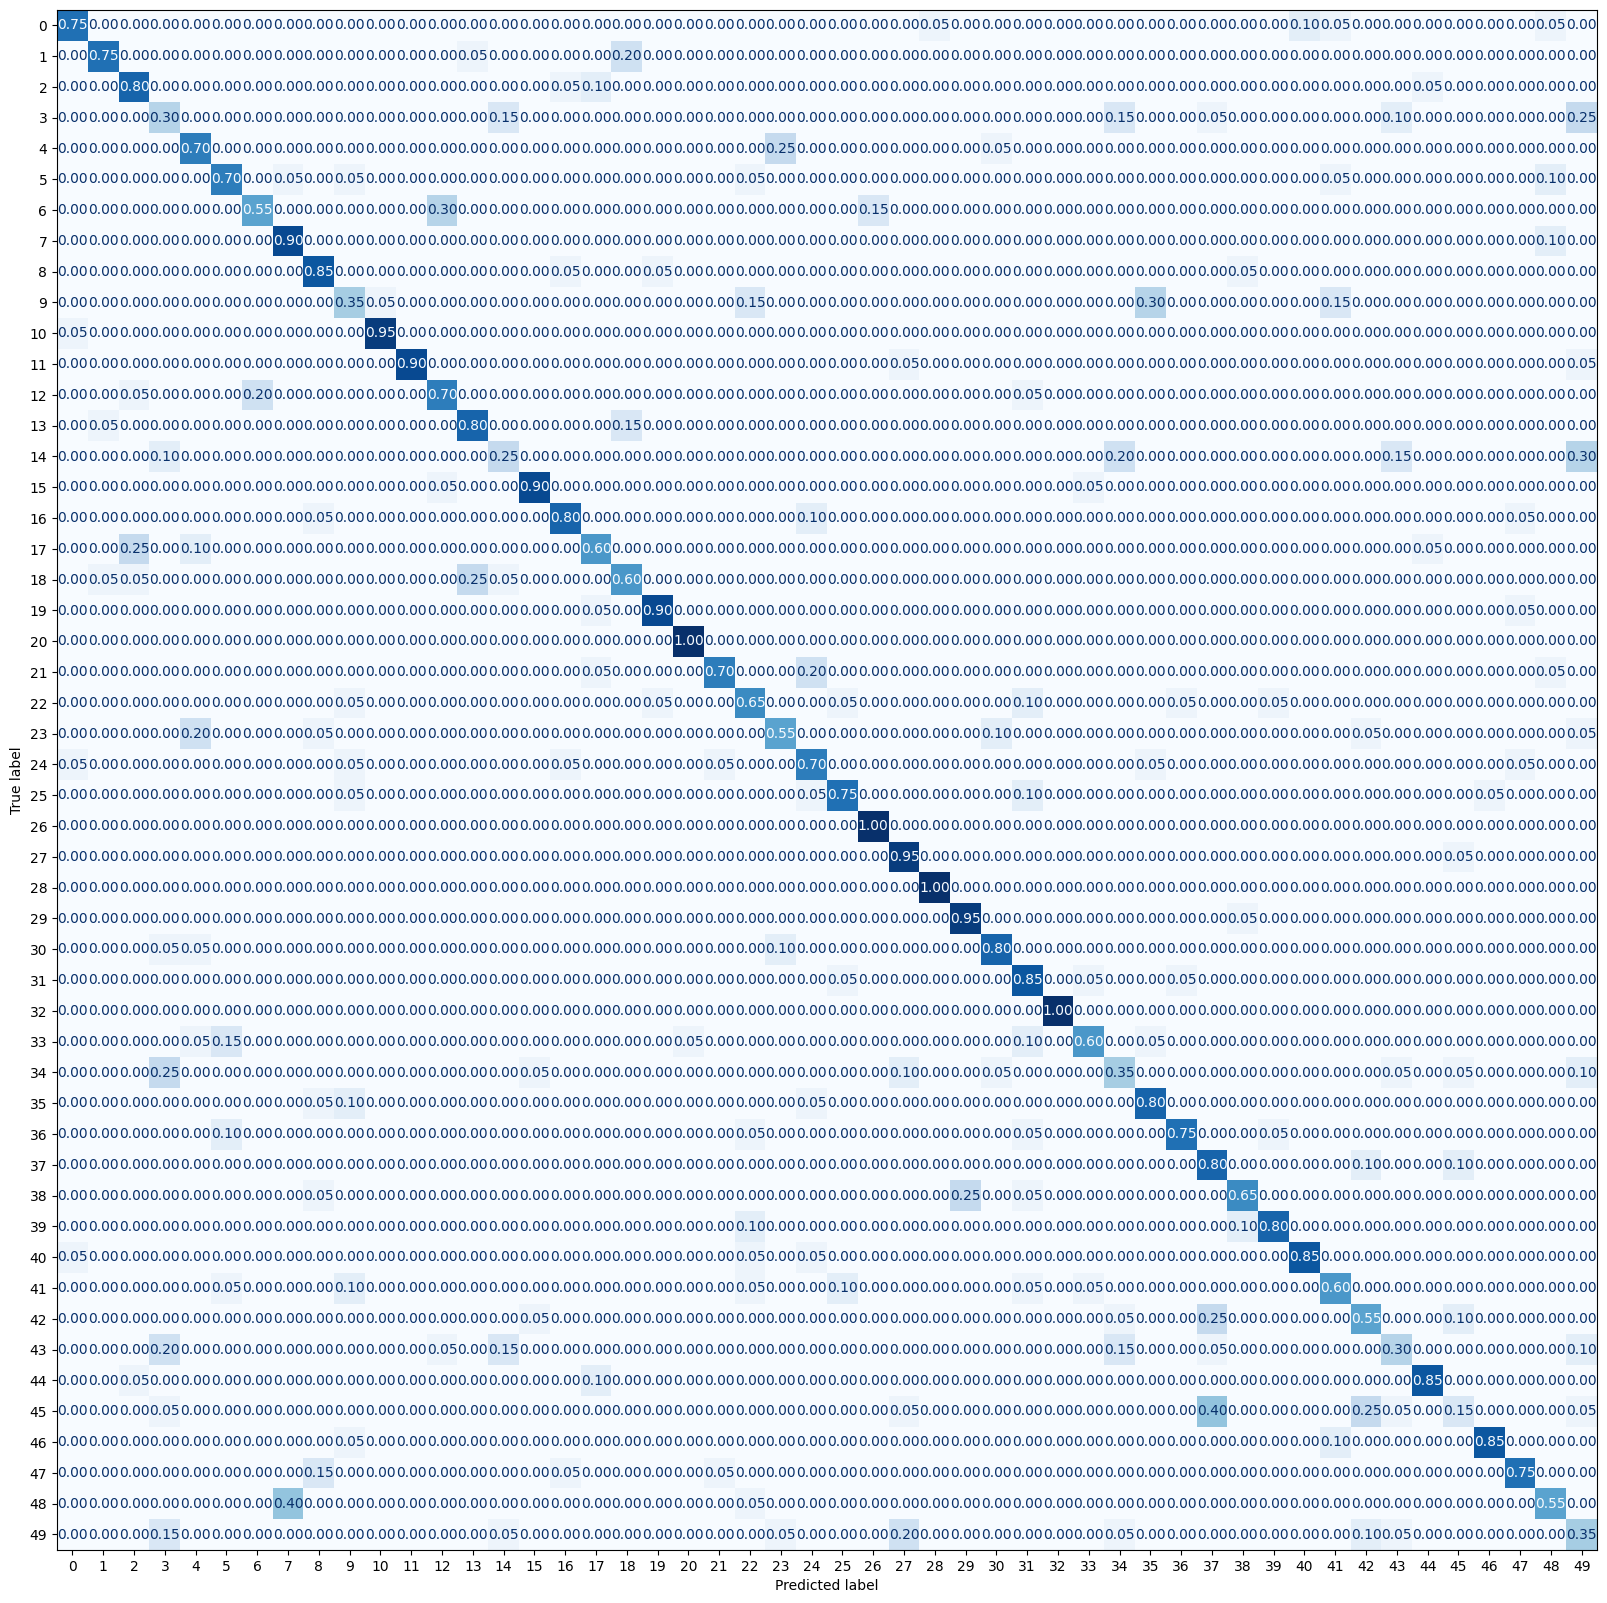

In [197]:
plot_confusion_matrix(test_pred, test_y, labels=sorted(test['encoded-author'].unique().tolist()))


# Original Test Set Accuracies

    --71% accuracy for baseline (author labels)
    --80.5% accuracy for tfidf
    --85.2 % accuracy for w2v